In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [68]:
faults_diagnostics = pd.read_csv('../data/faults_diagnostics.csv',
                                 index_col='RecordID',
                                 parse_dates = ['EventTimeStamp', 'LocationTimeStamp'],
                                 low_memory = False)
#prepare derates for dummization
faults_diagnostics.loc[faults_diagnostics['spn'] != 1569, 'spn_derate'] = 'neither' 
faults_diagnostics.loc[faults_diagnostics['spn'] != 5246, 'spn_derate'] = 'neither'
faults_diagnostics.loc[faults_diagnostics['spn'] == 5246, 'spn_derate'] = 'full'  
faults_diagnostics.loc[faults_diagnostics['spn'] == 1569, 'spn_derate'] = 'partial'  

#get dummies
derates = pd.get_dummies(faults_diagnostics['spn_derate'])

#merge back with original dataset
faults_diagnostics = faults_diagnostics.merge(derates, left_on = 'RecordID', right_on = 'RecordID') \
    .set_index('ESS_Id')

In [77]:
#Groupby at truck level
columns = ['EventTimeStamp', 'eventDescription',
           'ecuSoftwareVersion', 'ecuModel', 'ecuMake', 'spn', 'fmi', 'active',
           'activeTransitionCount', 'EquipmentID', 'Latitude', 'Longitude',
           'LocationTimeStamp', 'AcceleratorPedal', 'BarometricPressure',
           'CruiseControlActive', 'CruiseControlSetSpeed', 'DistanceLtd',
           'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
           'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
           'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus',
           'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake', 'Speed',
           'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
           'spn_derate', 'full', 'neither', 'partial']

faults_diagnostics = faults_diagnostics.groupby('EquipmentID')[columns].head()

In [84]:
#computer. Show me all the columns, please.
pd.set_option('display.max_columns', 40)

In [78]:
faults_diagnostics[faults_diagnostics['spn']==1569]

,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,
108644439,2000-03-19 14:02:34,Condition Exists Engine Protection Torque Derate,04358814*06086133*051718174436*09401683*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1968,38.294259,-85.757083,...,True,84.2,18431,False,62.438100,NaN,100.0,25.81,partial,0,0,1
77308356,2011-01-01 00:03:34,Condition Exists Engine Protection Torque Derate,05317106*04101156*020516150530*09400053*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,1,1751,38.344490,-85.711712,...,True,96.8,22527,False,9.689507,NaN,100.0,1.45,partial,0,0,1
14627707,2011-01-01 00:05:58,Condition Exists Engine Protection Torque Derate,unknown,unknown,unknown,1569,31,False,2,1917,36.011944,-83.873750,...,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
990856,2015-02-21 12:06:22,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,5,1721,39.051805,-84.560509,...,True,51.8,18431,False,51.971870,3276.75,0.0,0.58,partial,0,0,1
993542,2015-02-21 15:01:49,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,5,1721,38.113240,-85.667361,...,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
994045,2015-02-21 15:35:45,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,6,1721,37.735185,-85.808101,...,True,91.4,18431,False,40.738650,3276.75,0.0,15.66,partial,0,0,1
994237,2015-02-21 15:51:58,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,False,6,1721,37.540370,-85.880972,...,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,partial,0,0,1
994680,2015-02-21 16:22:24,Condition Exists Engine Protection Torque Derate,05317106*04047493*092613211021*09300006*G1*BDR*,6X1u13D1500000000,CMMNS,1569,31,True,7,1721,37.166666,-85.964027,...,True,60.8,18431,False,55.399120,3276.75,0.0,0.87,partial,0,0,1
1007750,2015-02-22 19:44:55,Condition Exists Engine Protection Torque Derate,04993120*00027849*082113134117*07700053*I0*BBZ*,6X1u10D1500000000,CMMNS,1569,31,True,1,1395,36.066203,-86.434814,...,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,partial,0,0,1


In [79]:
faults_diagnostics[faults_diagnostics['spn']==5246]

,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuModel,ecuMake,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,...,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_derate,full,neither,partial
ESS_Id,,,,,,,,,,,,,,,,,,,,,,,,,
119019218,2011-01-01 00:03:22,NaN,04384413*22115617*090617144354*60701715*G1*BGT*,6X1u17D1500000000,CMMNS,5246,16,True,1,2175,33.259027,-84.096666,...,True,93.2,6143,True,0.000000,NaN,100.0,0.00,full,1,0,0
119019219,2011-01-01 00:03:23,NaN,04384413*22115617*090617144354*60701715*G1*BGT*,6X1u17D1500000000,CMMNS,5246,0,True,1,2175,33.259027,-84.096666,...,True,93.2,6143,True,0.000000,NaN,100.0,0.00,full,1,0,0
77308358,2011-01-01 00:03:34,NaN,05317106*04101156*020516150530*09400053*G1*BDR*,6X1u13D1500000000,CMMNS,5246,0,True,1,1751,38.344490,-85.711712,...,True,96.8,22527,False,9.689507,NaN,100.0,1.45,full,1,0,0
7367914,2011-01-01 00:04:57,NaN,04993120*00041643*042114185815*07700062*I0*BBZ*,6X1u10D1500000000,CMMNS,5246,0,True,1,1452,39.616250,-84.231666,...,True,77.0,22527,True,0.000000,NaN,NaN,0.00,full,1,0,0
990931,2015-02-21 12:10:51,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,6X1u10D1500000000,CMMNS,5246,0,True,1,1395,36.065972,-86.433425,...,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,full,1,0,0
1007751,2015-02-22 19:44:55,NaN,04993120*00027849*082113134117*07700053*I0*BBZ*,6X1u10D1500000000,CMMNS,5246,0,True,1,1395,36.066203,-86.434814,...,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,full,1,0,0
1070646,2015-02-25 13:53:08,NaN,unknown,unknown,unknown,5246,0,True,1,1329,39.399583,-82.974768,...,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,full,1,0,0
1071907,2015-02-25 14:47:00,NaN,unknown,unknown,unknown,5246,0,False,1,1329,39.399629,-82.974814,...,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,full,1,0,0
1176400,2015-03-04 08:10:53,NaN,unknown,unknown,unknown,5246,0,True,1,1509,39.942777,-82.021666,...,True,NaN,22527,NaN,NaN,NaN,NaN,NaN,full,1,0,0


In [7]:
faults_diagnostics.select_dtypes(include=['int64','float64']).columns

Index(['Unnamed: 0', 'ESS_Id', 'spn', 'fmi', 'activeTransitionCount',
       'EquipmentID', 'Latitude', 'Longitude', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
       'LampStatus', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure'],
      dtype='object')

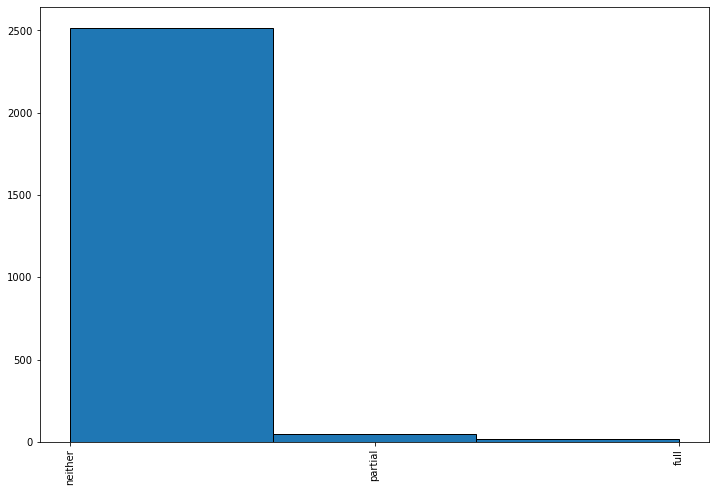

In [88]:
plt.figure(figsize=(12, 8))
plt.hist(faults_diagnostics['spn_derate'], bins = 3, edgecolor = 'black')
plt.xticks(rotation = 90);

In [80]:
variables = ['EventTimeStamp','LocationTimeStamp','spn','EquipmentID','activeTransitionCount',
             'Latitude', 'Longitude', 'AcceleratorPedal',
             'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd',
             'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
             'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
             'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
             'LampStatus', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
             'TurboBoostPressure']
target = ['full', 'partial', 'neither']
X = faults_diagnostics[variables]
y = faults_diagnostics[target]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 321)

In [82]:
oversampler = SMOTE(k_neighbors=5, random_state=321)

In [83]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

AttributeError: 'DataFrame' object has no attribute 'argmax'

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x = X_smote.x, y = X_smote.y, hue = y_smote, ax = ax);

In [ ]:
lr = LogisticRegression()
lr.fit(X_smote, y_smote)

In [ ]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))